In [48]:
using Revise
using SciBmad
using CairoMakie # Plotting package
using Optim # Optimization package
using GTPSA # For gradients wrt Twiss parameters
using StaticArrays, LinearAlgebra # For performance + utility

set_theme!(theme_latexfonts()) # Use LaTeX font for plotting
GTPSA.show_eps=1e-12; # Hides tiny monomials in output

In [49]:
include("esr-v6.3.1-noDA.jl");

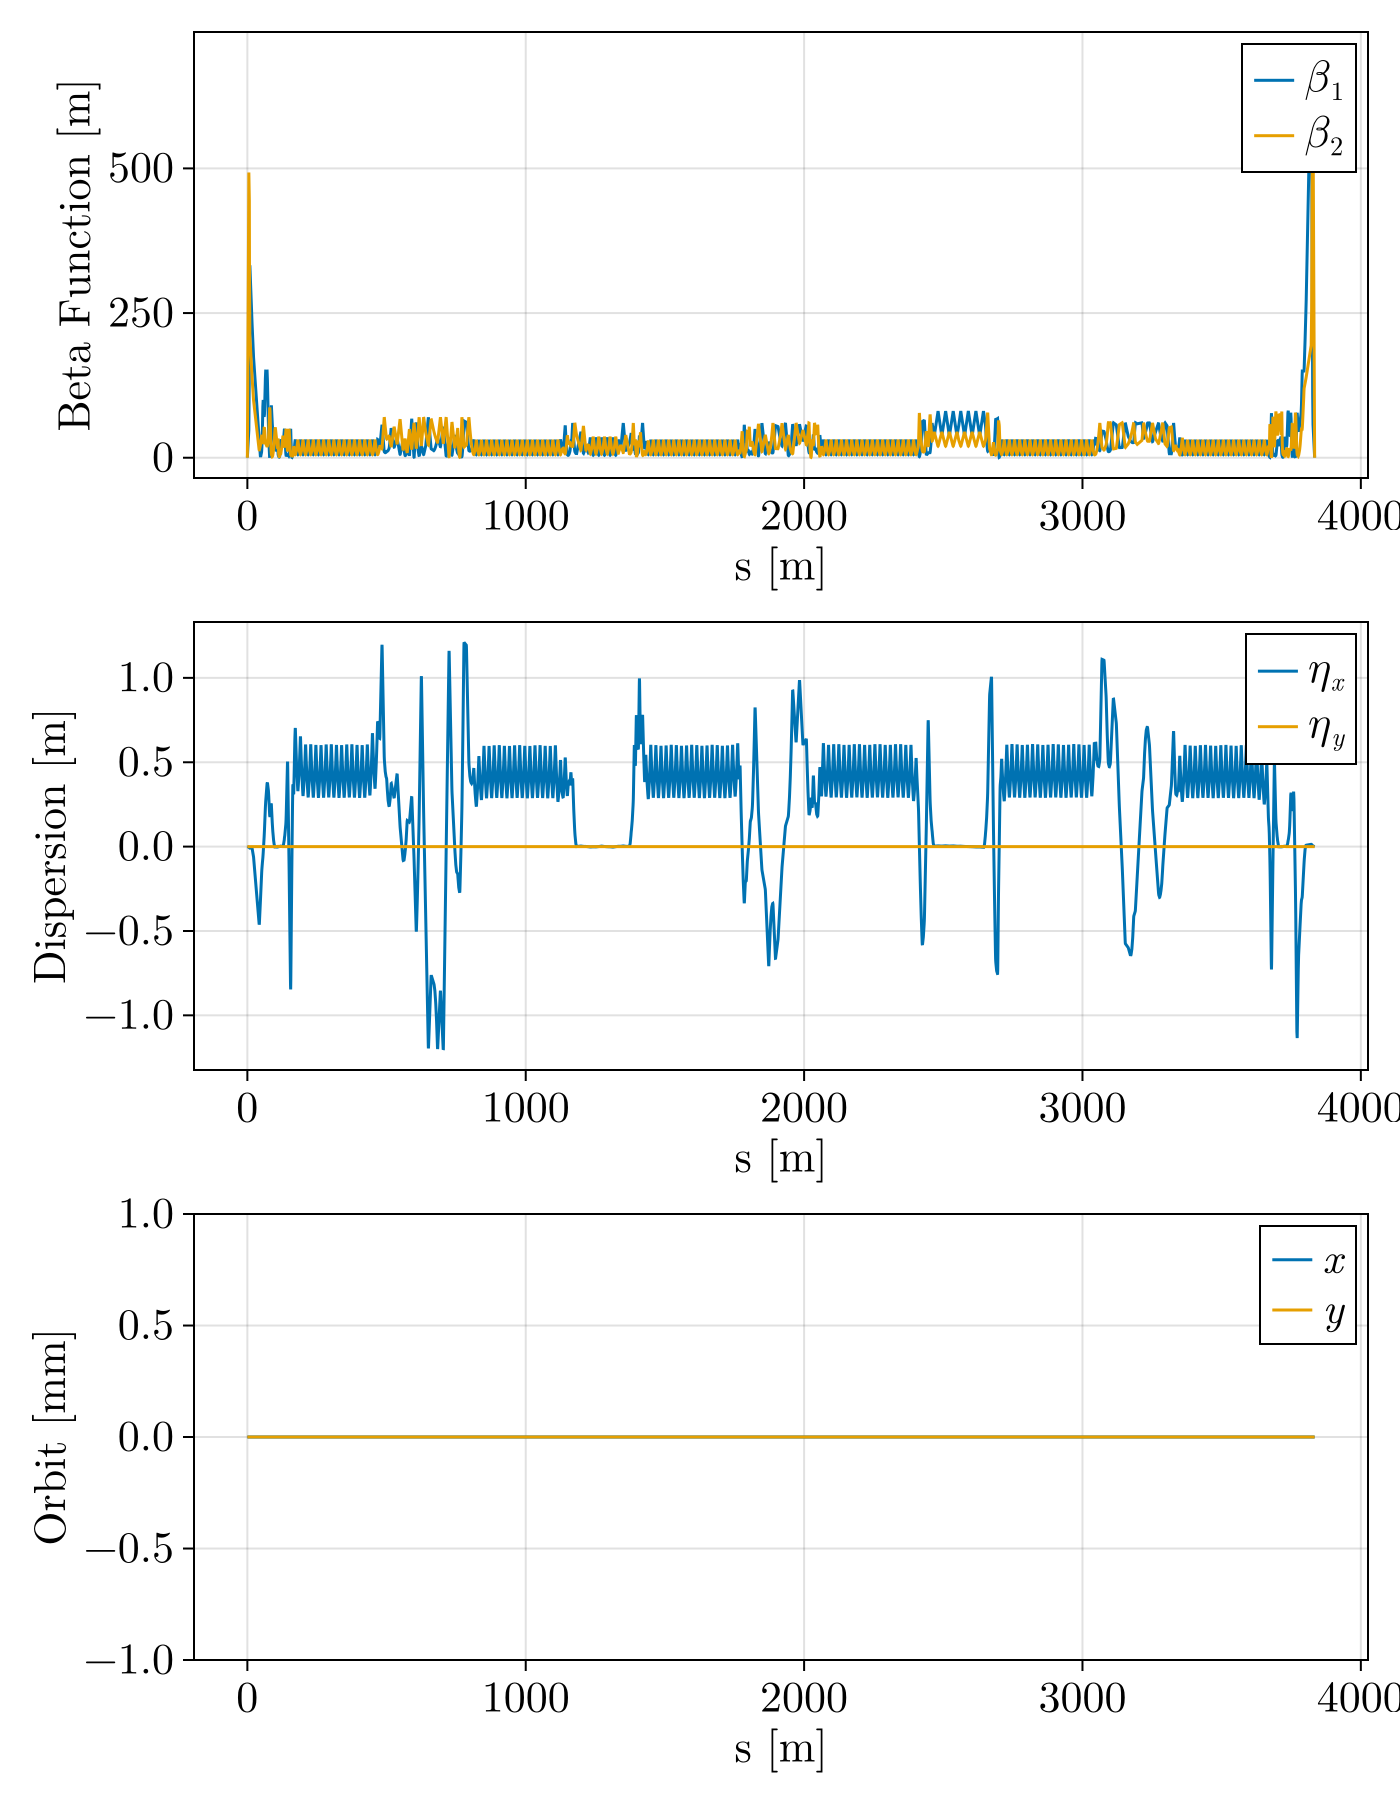

In [50]:
tw = twiss(ring)
t = tw.table

eta_1 = map(x->x[6], t.orbit_x)
eta_2 = map(x->x[6], t.orbit_y)

# Plot the betas, dispersion, orbit:
f = Figure(fontsize=22, size=(700,3*300));
ax1 = Axis(f[1, 1], xlabel="s [m]", ylabel="Beta Function [m]");
ax2 = Axis(f[2, 1], xlabel="s [m]", ylabel="Dispersion [m]");
ax3 = Axis(f[3, 1], xlabel="s [m]", ylabel="Orbit [mm]");

lines!(ax1, t.s, t.beta_1, label=L"\beta_1"); 
lines!(ax1, t.s, t.beta_2, label=L"\beta_2");
lines!(ax2, t.s, eta_1, label=L"\eta_x"); 
lines!(ax2, t.s, eta_2, label=L"\eta_y");
lines!(ax3, t.s, scalar.(t.orbit_x), label=L"x"); 
lines!(ax3, t.s, scalar.(t.orbit_y), label=L"y");

axislegend(ax1, position=:rt);
axislegend(ax2, position=:rt);
axislegend(ax3, position=:rt);

display(f);

In [51]:
# Tunes:
tw.tunes

3-element SVector{3, TPS64{GTPSA.Dynamic}}:
Descriptor(NV=6, MO=1)
 Index Coefficient                Order   Exponent
--------------------------------------------------------------------
   1:   8.0000003224447711e-02      0      0   0   0   0   0   0
--------------------------------------------------------------------
   2:   1.3999999903914259e-01      0      0   0   0   0   0   0
--------------------------------------------------------------------
   3:  -2.3124330713838033e+00      1      0   0   0   0   0   1


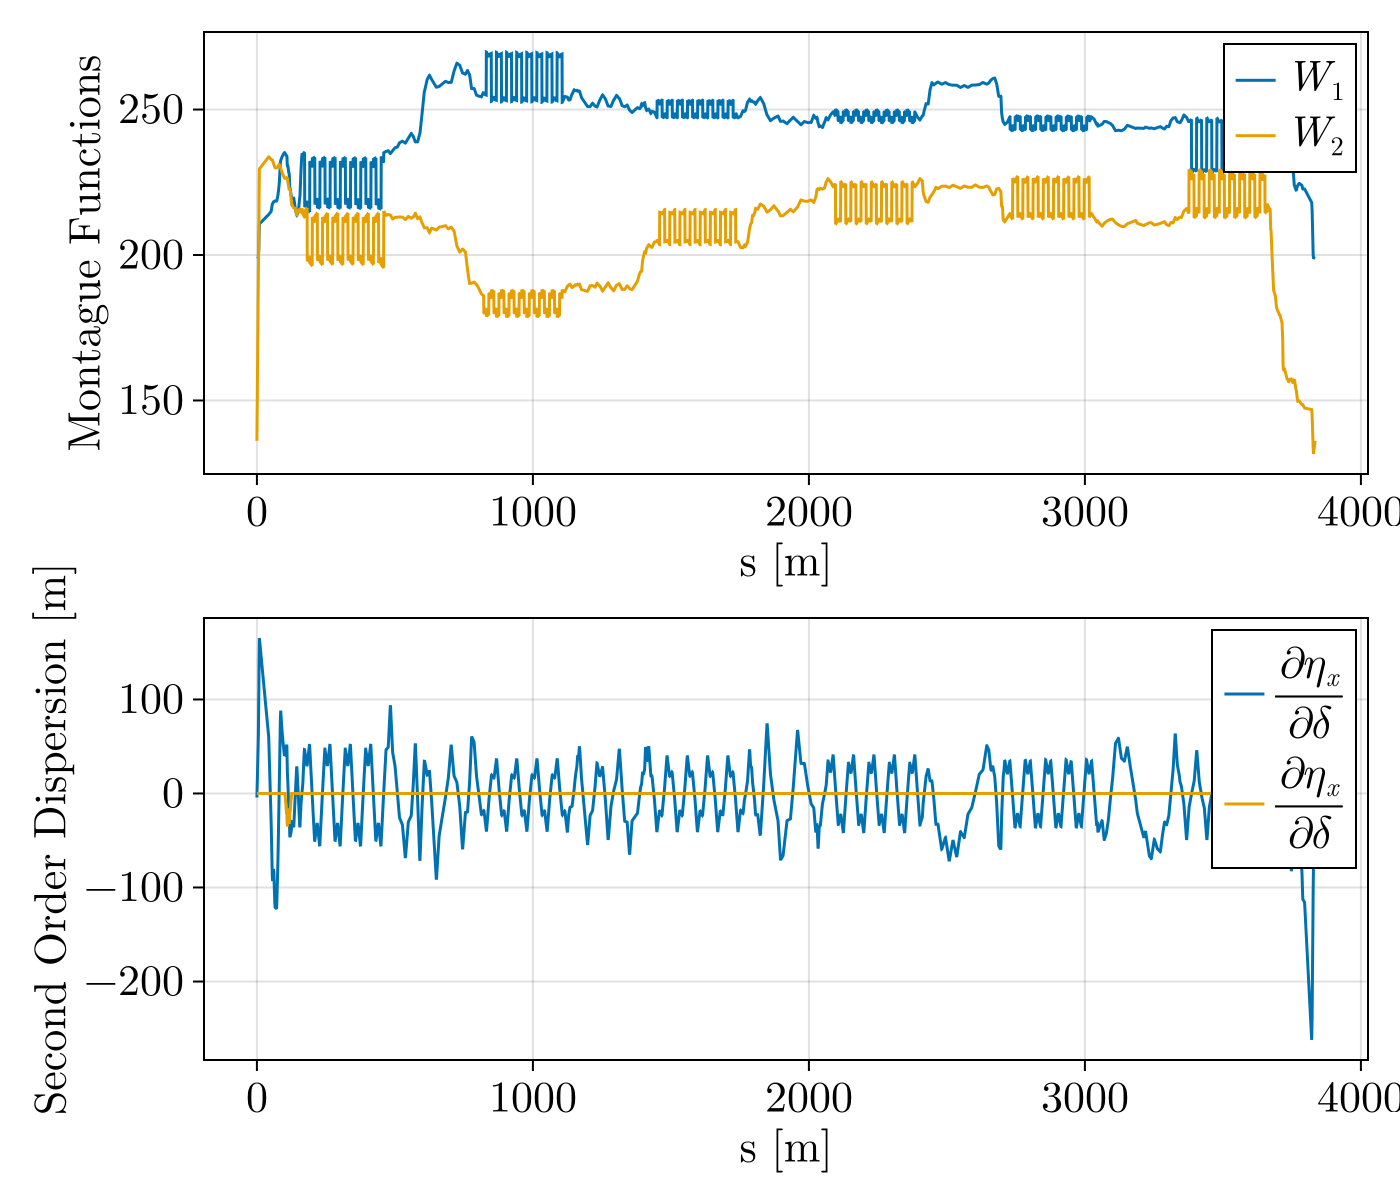

In [53]:
# Second order
tw2 = twiss(ring; GTPSA_descriptor=Descriptor(6, 2)) #, at=filter(x->x.kind=="Marker", ring.line))
t2 = tw2.table

deta_ddelta_x = map(x->x[[0,0,0,0,0,2]], t2.orbit_x)
deta_ddelta_y = map(x->x[[0,0,0,0,0,2]], t2.orbit_y)
beta_1 = scalar.(t2.beta_1)
beta_2 = scalar.(t2.beta_2)
dbeta_ddelta_1 = map(x->x[[0,0,0,0,0,1]], t2.beta_1)
dbeta_ddelta_2 = map(x->x[[0,0,0,0,0,1]], t2.beta_2)
alpha_1 = scalar.(t2.alpha_1)
alpha_2 = scalar.(t2.alpha_2)
dalpha_ddelta_1 = map(x->x[[0,0,0,0,0,1]], t2.alpha_1)
dalpha_ddelta_2 = map(x->x[[0,0,0,0,0,1]], t2.alpha_2)
W_1 = @. sqrt((dalpha_ddelta_1-alpha_1/beta_1*dbeta_ddelta_1)^2 + (dbeta_ddelta_1/beta_1)^2)
W_2 = @. sqrt((dalpha_ddelta_2-alpha_2/beta_2*dbeta_ddelta_2)^2 + (dbeta_ddelta_2/beta_2)^2)

# Plot these guys
f = Figure(fontsize=22, size=(700,2*300));
ax1 = Axis(f[1, 1], xlabel="s [m]", ylabel="Montague Functions");
ax2 = Axis(f[2, 1], xlabel="s [m]", ylabel="Second Order Dispersion [m]");

lines!(ax1, t2.s, W_1, label=L"W_1"); 
lines!(ax1, t2.s, W_2, label=L"W_2");
lines!(ax2, t2.s, deta_ddelta_x, label=L"\frac{\partial\eta_x}{\partial\delta}"); 
lines!(ax2, t2.s, deta_ddelta_y, label=L"\frac{\partial\eta_x}{\partial\delta}");

axislegend(ax1, position=:rt);
axislegend(ax2, position=:rt);
axislegend(ax3, position=:rt);

display(f);

In [54]:
# ADTs (chromaticities)
tw2.tunes

3-element SVector{3, TPS64{GTPSA.Dynamic}}:
Descriptor(NV=6, MO=2)
 Index Coefficient                Order   Exponent
--------------------------------------------------------------------
   1:   8.0000003224447711e-02      0      0   0   0   0   0   0
   1:   1.0191066171446810e+00      1      0   0   0   0   0   1
--------------------------------------------------------------------
   2:   1.3999999903914259e-01      0      0   0   0   0   0   0
   2:   9.8314009503290645e-01      1      0   0   0   0   0   1
--------------------------------------------------------------------
   3:  -2.3124330713838033e+00      1      0   0   0   0   0   1
   3:   6.4032357232905195e+00      2      1   1   0   0   0   0
   3:   6.1772514000128549e+00      2      0   0   1   1   0   0
   3:  -3.1014388201607477e+00      2      0   0   0   0   0   2


In [55]:
# Seems like chromaticity not perfectly optimized. 
# First just make all focusing sextupoles one knob,
# defocusing other knob
sextupoles = filter(x->x.kind=="Sextupole", ring.line)
chrom_sextupoles = filter(x->x.Kn2 != 0, sextupoles)

sfs = filter(x->x.Kn2 > 0, chrom_sextupoles)
sds = filter(x->x.Kn2 < 0, chrom_sextupoles)

# Now can apply knob
# Let's first do that
module Controls end
Controls.K2F = 0
Controls.K2D = 0

foreach(x->x.Kn2 = DefExpr(()->Controls.K2F), sfs)
foreach(x->x.Kn2 = DefExpr(()->Controls.K2D), sds)

In [79]:
# Now use AD to make chromaticities +1

# Define function to return objective function (F) AND 
# gradient (G) IF PROVIDED:
function f_and_grad!(F, G, u, p)
    ring = p[1]
    control_mod = p[2]
    weight = p[3]
    chrom1_goal = p[4]
    chrom2_goal = p[5]

    if G !== nothing
        # 6 variables to 2nd order, 2 parameters to 1st order
        dchrom = Descriptor(6, 3, 2, 1)
        Δk = params(dchrom)
        control_mod.K2F = u[1] + Δk[1]
        control_mod.K2D = u[2] + Δk[2]
        tw = twiss(ring; GTPSA_descriptor=dchrom, at=[]) # at no elements, only tunes
        # Construct Jacobian
        chrom1 = tw.tunes[1][6]
        dchrom1_dK2F = tw.tunes[1][[6=>1],params=[1=>1]]#this uses sparse monomial indexing, alternatively [[0,0,0,0,0,1,1,0]]
        dchrom1_dK2D = tw.tunes[1][[6=>1],params=[2=>1]]# [[0,0,0,0,0,1,0,1]]
        #println(tw.tunes[1])
        chrom2 = tw.tunes[2][6]
        dchrom2_dK2F = tw.tunes[2][[6=>1],params=[1=>1]]
        dchrom2_dK2D = tw.tunes[2][[6=>1],params=[2=>1]]
        dQs_dV = tw.tunes[3][param=1]

        # Apply to gradient of sum of squares
        res = SA[chrom1-chrom1_goal, chrom2-chrom2_goal]
        J = SA[dchrom1_dK2F dchrom1_dK2D; dchrom2_dK2F dchrom2_dK2D]
        G .= 2*transpose(J)*res

        if F !== nothing
            return sum(abs2, res)
        end
    elseif F !== nothing # Just compute Qs, no derivative 
        # This is for gradient-free optimizers
        control_mod.K2F = u[1]
        control_mod.K2D = u[2]
        tw = twiss(ring; GTPSA_descriptor=Descriptor(6, 2), at=[]) # at no elements, only tunes
        chrom1 = tw.tunes[1][6]
        chrom2 = tw.tunes[2][6]
        res = SA[chrom1-chrom1_goal, chrom2-chrom2_goal] 
        return sum(abs2, res)
    end
end

# Optimize using Optim.jl
u0 = [2.5230882715314, -3.385942324738] # initial guess, use K2s already there
p = (ring, Controls, 1, 1.0, 1.0)

# Define closure with parameters
# Use Optim.NLSolversBase.only_fg! to specify f_and_gradient provided:
f = Optim.NLSolversBase.only_fg!((F,G,u)->f_and_grad!(F,G,u,p))

# Optimize
sol = Optim.optimize(f, u0, LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     1.622762e-25

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 9.20e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.72e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.04e-05 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.40e+19 ≰ 0.0e+00
    |g(x)|                 = 3.69e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    2
    f(x) calls:    6
    ∇f(x) calls:   6


In [80]:
Controls.K2F = sol.minimizer[1]
Controls.K2D = sol.minimizer[2]

-3.3863291580906236

In [81]:
sol.minimum

1.622762316863683e-25

In [78]:
twiss(ring; GTPSA_descriptor=Descriptor(6,2), at=[]).tunes

3-element SVector{3, TPS64{GTPSA.Dynamic}}:
Descriptor(NV=6, MO=2)
 Index Coefficient                Order   Exponent
--------------------------------------------------------------------
   1:   8.0000003224449140e-02      0      0   0   0   0   0   0
   1:   9.9999999999961742e-01      1      0   0   0   0   0   1
--------------------------------------------------------------------
   2:   1.3999999903914501e-01      0      0   0   0   0   0   0
   2:   1.0000000000001261e+00      1      0   0   0   0   0   1
--------------------------------------------------------------------
   3:  -2.3124330713838033e+00      1      0   0   0   0   0   1
   3:   6.2831853071765540e+00      2      1   1   0   0   0   0
   3:   6.2831853071858692e+00      2      0   0   1   1   0   0
   3:  -3.1029043992808374e+00      2      0   0   0   0   0   2


In [ ]:
# Turns out that's really the best we can do

In [ ]:
# These are the elements where Yunhai put trombones
# MLRF_6
# MLRR_6
# IP8
# IP10
# IP12
# IP2